# Data Processing of YouTube Data

Includes running some regression and predictive ML algorithms

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import bartlett

import matplotlib.pyplot as plt

In [2]:
def adj_r2_score(y, y_pred, X):
    return 1 - (1-r2_score(y, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

## Read data from BQ

In [3]:
gcs_project_id = "wide-hexagon-397214"
gcs_dataset  = "youtube_data"

**Channel Data**

In [4]:
query_channel = """

SELECT *
FROM `{gcs_project_id}.{gcs_dataset}.{table_name}`

""".format(gcs_project_id=gcs_project_id,
           gcs_dataset=gcs_dataset,
           table_name="channel_info"
          )

In [5]:
channel_info = pd.read_gbq(query_channel,
                           project_id=gcs_project_id,
                           dialect="standard",
                           progress_bar_type="tqdm")

print(channel_info.shape)
channel_info.head(5)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████|
(45, 7)


,channel_name,view_count,subscriber_count,video_count,channel_id,playlist_id,load_timestamp
0,Harsh Kumar,76429,705,14,UCueeXkuJezkCqu0YryvJnnQ,UUueeXkuJezkCqu0YryvJnnQ,2023-10-16 12:03:46.700888+00:00
1,Thu Vu data analytics,5514835,169000,75,UCJQJAI7IjbLcpsjWdSzYz0Q,UUJQJAI7IjbLcpsjWdSzYz0Q,2023-10-16 12:03:46.700888+00:00
2,amitvarma,144823,5740,16,UCs8a-hjf6X4pa-O0orSoC8w,UUs8a-hjf6X4pa-O0orSoC8w,2023-10-16 12:03:46.700888+00:00
3,Harsh Kumar,76490,706,14,UCueeXkuJezkCqu0YryvJnnQ,UUueeXkuJezkCqu0YryvJnnQ,2023-10-17 12:01:16.334389+00:00
4,Thu Vu data analytics,5520237,169000,76,UCJQJAI7IjbLcpsjWdSzYz0Q,UUJQJAI7IjbLcpsjWdSzYz0Q,2023-10-17 12:01:16.334389+00:00


**Video Data**

In [6]:
query_channel = """

SELECT *
FROM `{gcs_project_id}.{gcs_dataset}.{table_name}`

""".format(gcs_project_id=gcs_project_id,
           gcs_dataset=gcs_dataset,
           table_name="video_details"
          )

In [7]:
video_details = pd.read_gbq(query_channel,
                           project_id=gcs_project_id,
                           dialect="standard",
                           progress_bar_type="tqdm")

print(video_details.shape)
video_details.head(5)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████|
(108, 8)


,video_id,title,published_at,view_count,like_count,comment_count,duration_sec,load_timestamp
0,rs8_I0sYGhw,isort for sorting Python imports #shorts #pyth...,2023-03-26 13:41:44+00:00,202,6,0,56.0,2023-10-31 14:31:03.045321+00:00
1,bhjaQssIXiw,pytest Tutorial: How to write tests in Python ...,2023-02-06 14:06:40+00:00,93,6,0,688.0,2023-10-31 14:31:03.045321+00:00
2,bURvz4g-XIg,flake8 for linting in Python #shorts #python #...,2023-03-19 18:34:57+00:00,125,7,1,53.0,2023-10-31 14:31:03.045321+00:00
3,GIEp0zNwtBA,Ranking Functions in SQL (Rank vs Dense_Rank v...,2021-06-22 14:50:31+00:00,458,14,1,254.0,2023-10-31 14:31:03.045321+00:00
4,uN1G1sZlELs,Decision Tree in Python using Scikit-Learn | T...,2021-04-01 13:35:45+00:00,10522,121,2,964.0,2023-10-31 14:31:03.045321+00:00


In [8]:
video_details.dtypes

video_id                       object
title                          object
published_at      datetime64[us, UTC]
view_count                      Int64
like_count                      Int64
comment_count                   Int64
duration_sec                  float64
load_timestamp    datetime64[us, UTC]
dtype: object

In [9]:
video_details = video_details.astype({
    "view_count": float,
    "like_count": float,
    "comment_count": float,
})

video_details.dtypes

video_id                       object
title                          object
published_at      datetime64[us, UTC]
view_count                    float64
like_count                    float64
comment_count                 float64
duration_sec                  float64
load_timestamp    datetime64[us, UTC]
dtype: object

## Summary Statistics

In [11]:
max_loadtime = channel_info.load_timestamp.max()
latest_channel_info = channel_info.loc[channel_info["load_timestamp"]==max_loadtime].copy()

In [12]:
latest_channel_info.describe(percentiles=[0.2,0.4,0.6,0.8])

,view_count,subscriber_count,video_count
count,3.0,3.0,3.0
mean,1947603.333333,59343.666667,36.0
std,3157268.520103,96737.88193,34.698703
min,77097.0,711.0,14.0
20%,115389.8,2954.6,15.6
40%,153682.6,5198.2,17.2
50%,172829.0,6320.0,18.0
60%,1256840.0,39256.0,29.6
80%,3424862.0,105128.0,52.8
max,5592884.0,171000.0,76.0


<Axes: xlabel='channel_name', ylabel='subscriber_count'>

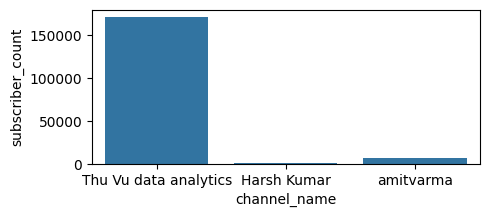

In [13]:
f, axs = plt.subplots(figsize=(5,2))
sns.barplot(data=latest_channel_info,
            x="channel_name",
            y="subscriber_count")

## Regression Plots

<Axes: xlabel='view_count', ylabel='like_count'>

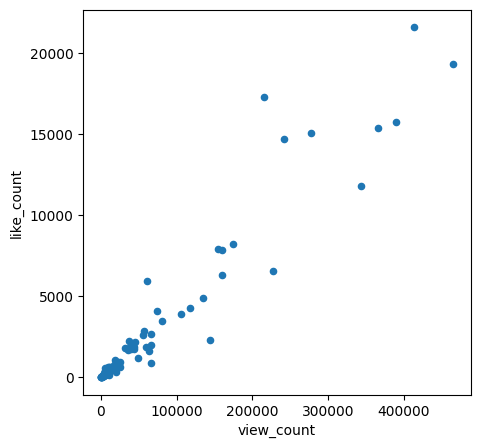

In [14]:
f, axs = plt.subplots(figsize=(5,5))
video_details.plot(x="view_count", y="like_count", kind="scatter", ax=axs)

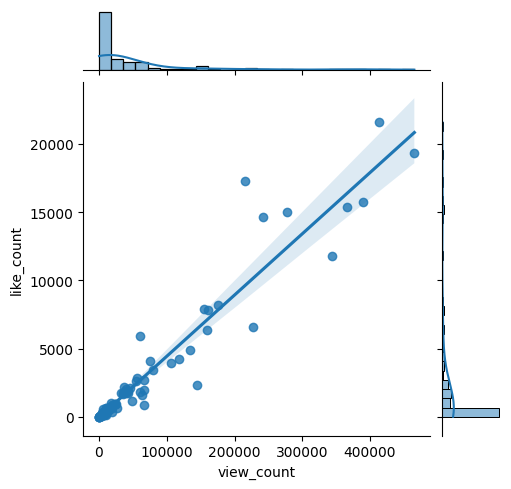

In [15]:
sns.jointplot(data=video_details, x="view_count", y="like_count", kind="reg", height=5)

## Correlations

In [16]:
np.corrcoef(video_details["view_count"], video_details["like_count"])

array([[1.        , 0.95923602],
       [0.95923602, 1.        ]])

In [17]:
video_details[["view_count","like_count","comment_count", "duration_sec"]].corr()

,view_count,like_count,comment_count,duration_sec
view_count,1.000000,0.959236,0.820723,-0.205735
like_count,0.959236,1.000000,0.755394,-0.212193
comment_count,0.820723,0.755394,1.000000,-0.095299
duration_sec,-0.205735,-0.212193,-0.095299,1.000000


In [18]:
video_details[["view_count","like_count","comment_count", "duration_sec"]].corr(method="spearman")

,view_count,like_count,comment_count,duration_sec
view_count,1.000000,0.950596,0.859674,0.050626
like_count,0.950596,1.000000,0.864997,-0.048042
comment_count,0.859674,0.864997,1.000000,0.257550
duration_sec,0.050626,-0.048042,0.257550,1.000000


<Axes: >

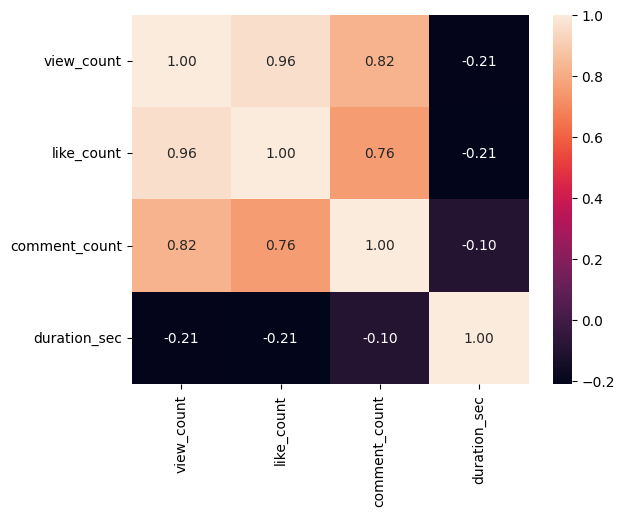

In [19]:
sns.heatmap(video_details[["view_count","like_count","comment_count", "duration_sec"]].corr(),
            annot=True,
            fmt=".2f")

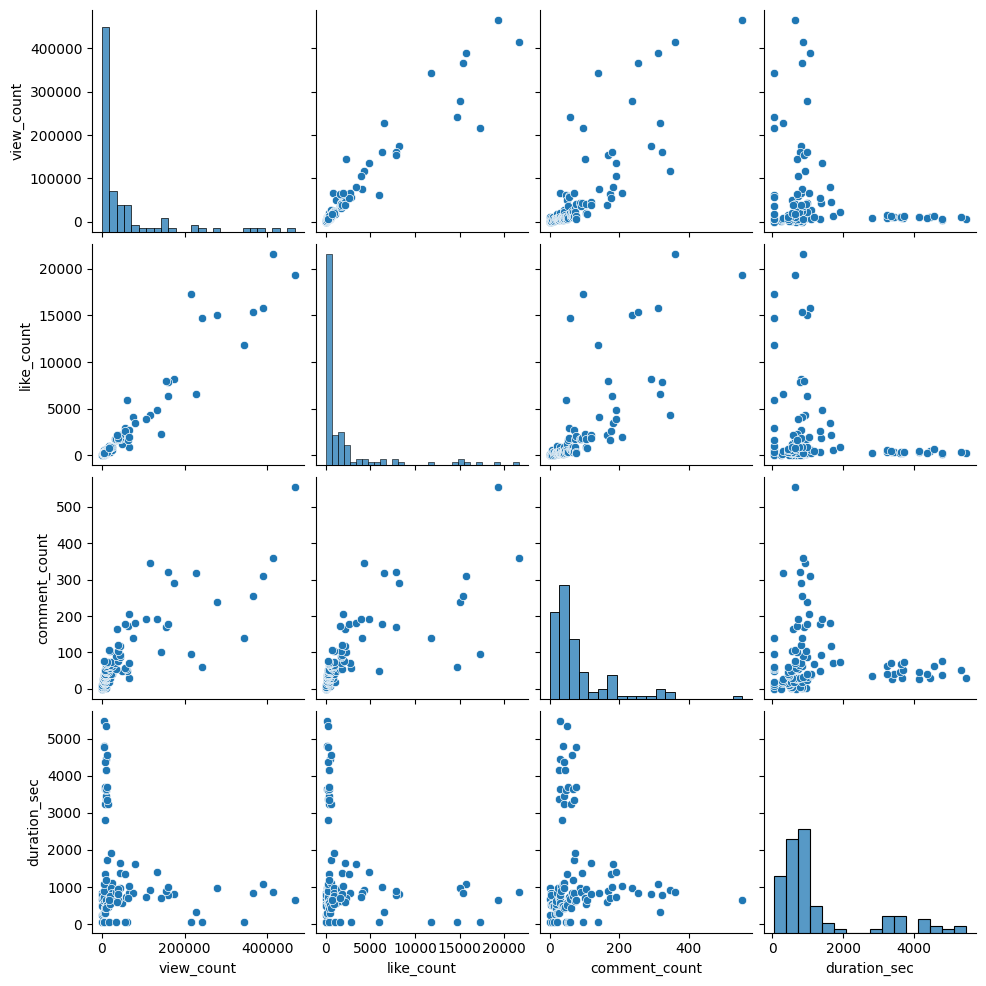

In [20]:
sns.pairplot(video_details)

## 1.) Regression: Direct formula (Views vs Likes)

**Regression equation**:
$$y_{i} = \beta_{0}+\beta_{1}x_{i}+\varepsilon_{i}$$

**Estimation of beta values**
$$\beta_{1} = \frac{SS_{xy}}{SS_{xx}}$$

$$\beta_{0} = \bar{y}-\beta_{1}\bar{x}$$
where...
$$SS_{xy} = \sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y}) = \sum_{i=1}^{n}x_{i}y_{i} - n\bar{x}\bar{y}$$

$$SS_{xx} = \sum_{i=1}^{n}(x_{i}-\bar{x})^2 = \sum_{i=1}^{n}x_{i}^2 - n(\bar{x})^2$$

In [21]:
def get_regression_coeff(x, y):
    n = len(x)

    x_mean = x.mean()
    y_mean = y.mean()

    ss_xy = sum(x*y) - n*x_mean*y_mean
    ss_xx = sum(x**2) - n*(x_mean**2)

    beta_1 = ss_xy/ss_xx
    beta_0 = y_mean - beta_1*x_mean

    return beta_0, beta_1

In [22]:
X = video_details["view_count"]
y = video_details["like_count"]

In [23]:
beta = get_regression_coeff(X, y)

In [24]:
print("""beta_0 = {:.4f}
beta_1 = {:.4f}""".format(beta[0], beta[1]))

beta_0 = -51.4660
beta_1 = 0.0449


In [25]:
y_pred = beta[0] + beta[1]*X

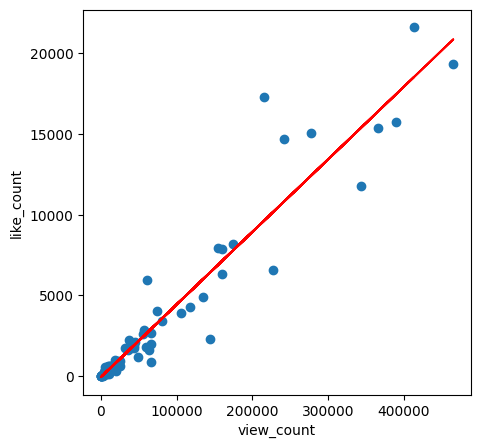

In [26]:
f, axs = plt.subplots(figsize=(5,5))
plt.scatter(X, y)
plt.plot(X, y_pred, color="r")

plt.xlabel("view_count")
plt.ylabel("like_count")
plt.show()

## 2.) Regression: Scikit (Views vs Likes)

In [27]:
X = video_details[["view_count"]]
y = video_details["like_count"]

### 2a.) All Data

In [28]:
linear_reg = linear_model.LinearRegression()

In [29]:
linear_reg.fit(X, y)

LinearRegression()

In [30]:
print("""Intercept = {:.4f}
Coefficient = {:.4f}""".format(linear_reg.intercept_, linear_reg.coef_[0]))

Intercept = -51.4660
Coefficient = 0.0449


In [31]:
y_pred = linear_reg.predict(X)

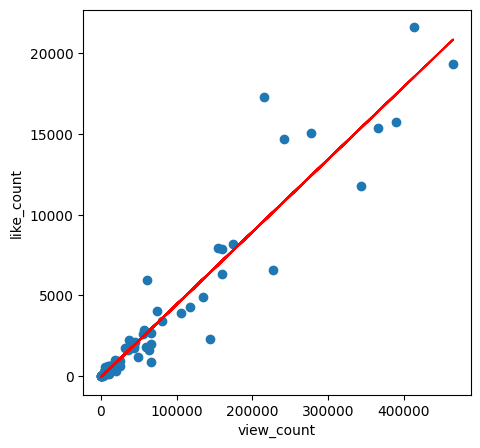

In [32]:
f, axs = plt.subplots(figsize=(5,5))
plt.scatter(X, y)
plt.plot(X, y_pred, color="r")

plt.xlabel("view_count")
plt.ylabel("like_count")
plt.show()

### 2b.) Train Data only

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [34]:
linear_reg = linear_model.LinearRegression()

In [35]:
linear_reg.fit(X_train, y_train)

LinearRegression()

In [36]:
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

In [37]:
print("""Intercept = {:.4f}
Coefficient = {:.4f}
R2 = {:.4f}
Adj R2 = {:.4f}""".format(linear_reg.intercept_,
                          linear_reg.coef_[0],
                          linear_reg.score(X_test, y_test),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

Intercept = -126.8252
Coefficient = 0.0469
R2 = 0.8493
Adj R2 = 0.8445


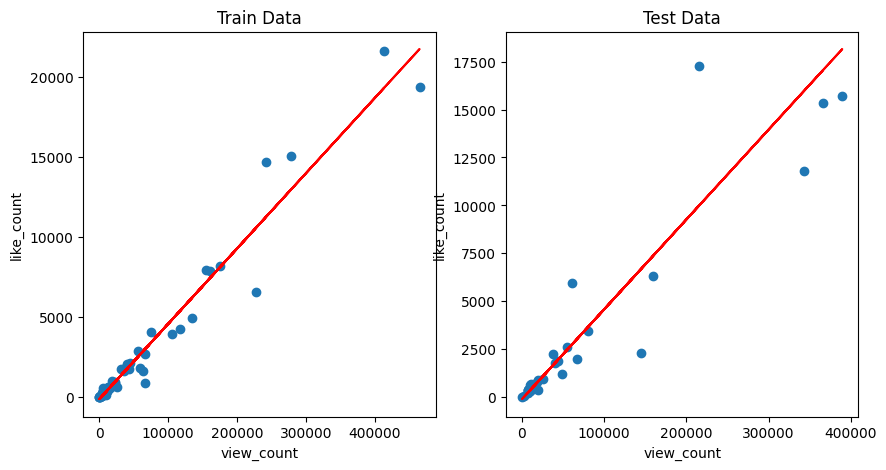

In [38]:
f, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].scatter(X_train, y_train)
axs[0].plot(X_train, y_train_pred, color="r")
axs[0].set_title('Train Data')
axs[0].set(xlabel='view_count', ylabel='like_count')

axs[1].scatter(X_test, y_test)
axs[1].plot(X_test, y_test_pred, color="r")
axs[1].set_title('Test Data')
axs[1].set(xlabel='view_count', ylabel='like_count')

plt.show()

## 3.) Regression: Scikit (Views vs Likes, Comments, Duration)

In [39]:
X = video_details[["view_count", "comment_count", "duration_sec"]]
y = video_details["like_count"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [41]:
linear_reg = linear_model.LinearRegression()

In [42]:
linear_reg.fit(X_train, y_train)

LinearRegression()

In [43]:
y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

In [44]:
print("""Intercept = {:.4f}
Coefficient = {:.4f}
R2 = {:.4f}
Adj R2 = {:.4f}""".format(linear_reg.intercept_,
                          linear_reg.coef_[0],
                          linear_reg.score(X_test, y_test),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

Intercept = 64.6455
Coefficient = 0.0568
R2 = 0.8121
Adj R2 = 0.7927


## 4.) Regression: statsmodels (Views vs Likes, Comments, Duration)

In [45]:
X = video_details[["view_count", "comment_count", "duration_sec"]]
y = video_details["like_count"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [47]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [48]:
ols_model = sm.OLS(y_train, X_train).fit()
ols_model

In [49]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             like_count   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     729.0
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           3.07e-53
Time:                        10:54:27   Log-Likelihood:                -602.00
No. Observations:                  75   AIC:                             1212.
Df Residuals:                      71   BIC:                             1221.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            64.6455    141.438      0.457      0.649    -217.375     346.666
view_count        0.0568      0.002     26.232      0.000       0.052       0.061
comment_count    -9.5638      1.850     -5.170      0.000     -13.252      -5.875
duration_sec      0.0610      0.068      0.904      0.369      -0.074       0.196
==============================================================================
Omnibus:                       44.486   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.183
Skew:                          -1.709   Prob(JB):                     1.12e-42
Kurtosis:                      10.081   Cond. No.                     1.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
y_train_pred = ols_model.predict(X_train)
y_test_pred = ols_model.predict(X_test)

In [51]:
print("""R2 = {:.4f}
Adj R2 = {:.4f}""".format(r2_score(y_test, y_test_pred),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

R2 = 0.8121
Adj R2 = 0.7853


## 5.) Regression: statsmodels with variable normalisation (Views vs Likes, Comments, Duration)

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
X = video_details[["view_count", "comment_count", "duration_sec"]]
y = video_details["like_count"]

In [54]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [56]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [57]:
ols_model = sm.OLS(y_train, X_train).fit()
ols_model

In [58]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             like_count   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     729.0
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           3.07e-53
Time:                        10:54:28   Log-Likelihood:                -602.00
No. Observations:                  75   AIC:                             1212.
Df Residuals:                      71   BIC:                             1221.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2442.4545     88.394     27.631      0.000    2266.202    2618.707
x1          5320.3055    202.815     26.232      0.000    4915.905    5724.706
x2          -891.6762    172.479     -5.170      0.000   -1235.591    -547.762
x3            83.0694     91.932      0.904      0.369    -100.237     266.376
==============================================================================
Omnibus:                       44.486   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.183
Skew:                          -1.709   Prob(JB):                     1.12e-42
Kurtosis:                      10.081   Cond. No.                         4.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
y_train_pred = ols_model.predict(X_train)
y_test_pred = ols_model.predict(X_test)

In [60]:
print("""R2 = {:.4f}
Adj R2 = {:.4f}""".format(r2_score(y_test, y_test_pred),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

R2 = 0.8121
Adj R2 = 0.7853


In [61]:
train = pd.DataFrame({"y": y_train,
                      "y_pred": y_train_pred,
                      "residuals": y_train-y_train_pred})

test = pd.DataFrame({"y":y_test,
                     "y_pred":y_test_pred,
                     "residuals": y_test-y_test_pred})

## Assumptions of linear regression

### i.) Linearity

Thereshould be a linear relationship between independent and dependent variables. If any variable is not linearly related, different model formulation like x^2 or log(x) can be tried

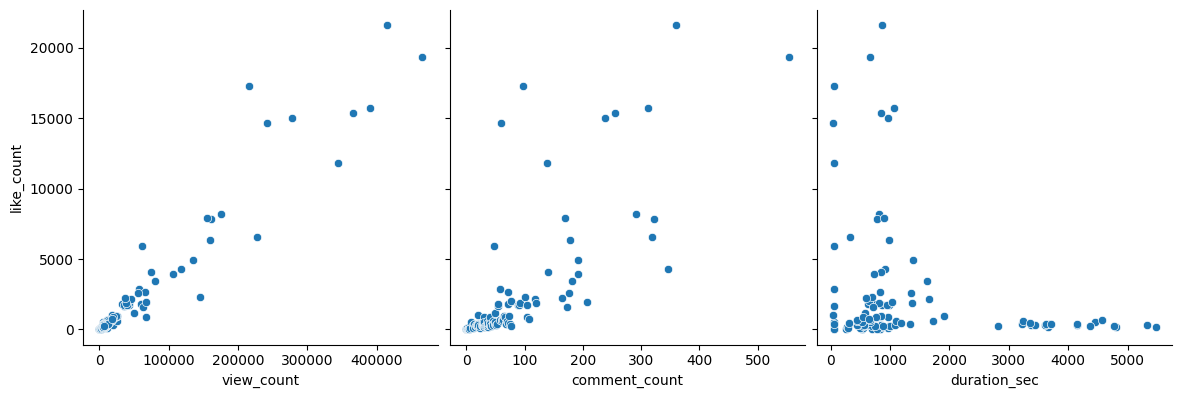

In [62]:
sns.pairplot(video_details,
             x_vars=["view_count", "comment_count", "duration_sec"],
             y_vars="like_count",
             height=4)

### ii) No multicollinearity
There should be no or little correlation between independent variables. If two variables are correlated, it would be better to drop one of them

**Test1**: Correlation between independent variables

<Axes: >

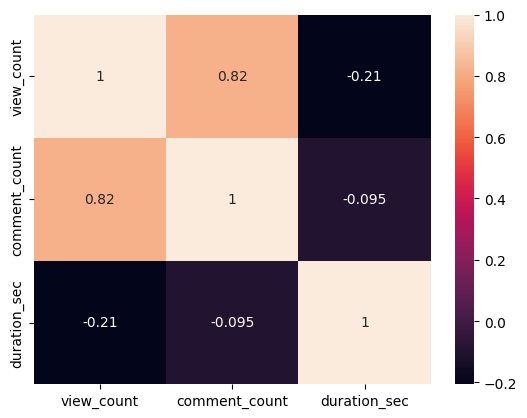

In [75]:
sns.heatmap(video_details[["view_count", "comment_count", "duration_sec"]].corr(), annot=True)

**Test2**: Variance Inflation Factor

The larger the value of VIF, the more correlated the variable is with other regressors. If there is no collinearity between two variables, VIF will be 1.  

It is calculated by taking a predictor and regressing it against every other predictor in the model.This gives the R² value which is then used in the VIF formula.

Usually a variable with VIF greater than 10 is considered to be troublesome, some people consider value above 5 to be problematic

$$VIF =\frac{1}{1-R^2}$$

In [81]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = []

df = video_details[["view_count", "comment_count", "duration_sec"]]

for i in range(df.shape[1]):
    vif.append(variance_inflation_factor(X_train, i))

pd.DataFrame({"feature": df.columns.to_list(), "vif": vif})

,feature,vif
0,view_count,1.011017
1,comment_count,4.593882
2,duration_sec,4.472935


**Finding**: Comment count and view count are highly correlated as seen from the correlation values. It is probably better to keep only view count for regression

### iii.) Normality of residuals
Residuals should be normally distributed with mean at zero

**Test1:** Mean of the residuals

In [94]:
print("""Mean of residuals = {}""".format(np.mean(test["residuals"])))

Mean of residuals = -208.79044820343887


**Test2**: Plotting KDE plot of residuals

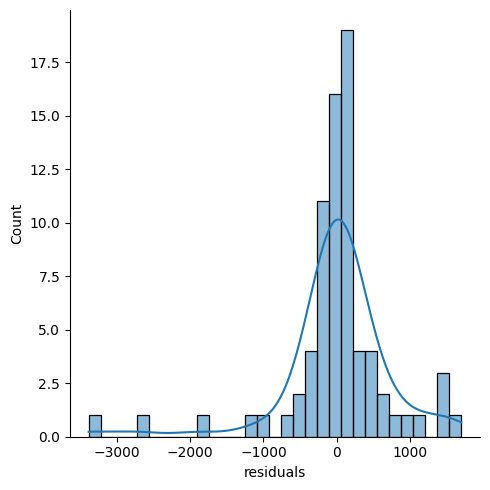

In [85]:
# train["residuals"].hist(bins=50)
sns.displot(train["residuals"], kde=True)

**Test3**: q-q plot

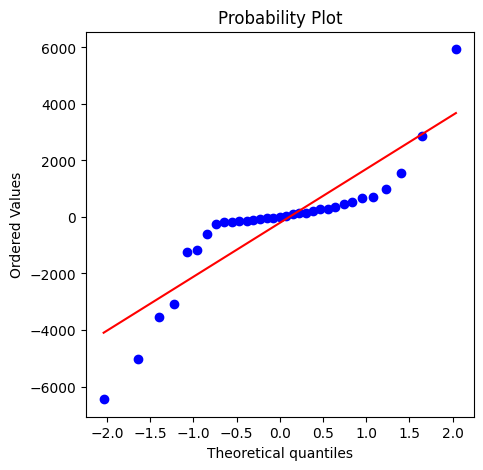

In [92]:
import scipy

f, axs = plt.subplots(figsize=(5,5))
scipy.stats.probplot(test["residuals"], plot=axs, fit=True)
plt.show()

**Finding**: Even though the distribution looks normal from KDE plot, the qq plot doesn't inspire confidence and it seems like the residuals are not normally distributed

### iv.) Homoscedasticity
The variance of residuals is constant for all values of independent variable X

One way to deal with heteroscedasticity is to transform the response variable Y using a concave function such as log Y or sqrt Y. Such a transformation leads to greater amount of shrinkage of larger responses leading to reduction in heteroscedasticity.

**Test1**: Plotting residuals vs predictions

In the below plot, we see residuals not uniformly distributed, but forming a cone. Residual values are lower for lower values of y_pred and higher for higher values of y_pred

<Axes: xlabel='y_pred', ylabel='residuals'>

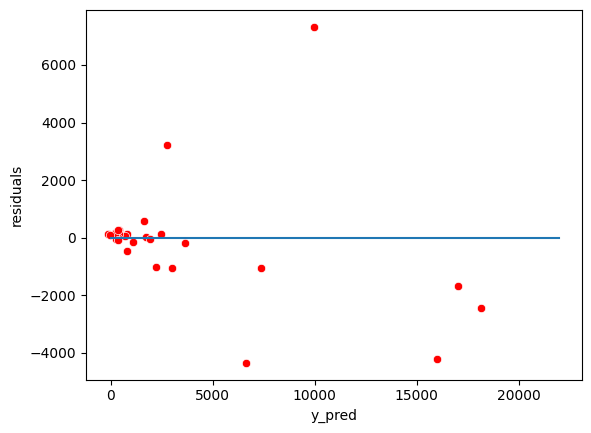

In [122]:
sns.scatterplot(x=test["y_pred"], y=test["residuals"], color="r")
sns.lineplot(x=[0,22000], y=[0,0])

**Test2**: Breusch-pagan test

Null Hypothesis Ho: Error variances are equal (Homoscedasticity)  
Alternate Hypothesis Ha: Error variances are not equal (Heteroscedasticity)

Returns  
lm : float: lagrange multiplier statistic  
lm_pvalue : float: p-value of lagrange multiplier test  
fvalue : float: f-statistic of the hypothesis that the error variance does not depend on x  
f_pvalue : float: p-value for the f-statistic  

In [108]:
from statsmodels.stats.diagnostic import het_breuschpagan
sms.het_breuschpagan(test["residuals"], X_test)

(22.55927816153241,
 4.989151524096698e-05,
 20.88677637447277,
 2.0941840995682486e-07)

In [109]:
bptest = het_breuschpagan(test["residuals"], X_test)[1]
print("The p value of Breuchpagen test is", bptest)

The p value of Breuchpagen test is 4.989151524096698e-05


### v.) No autocorrelation of residuals

**Test1**: Plot residuals

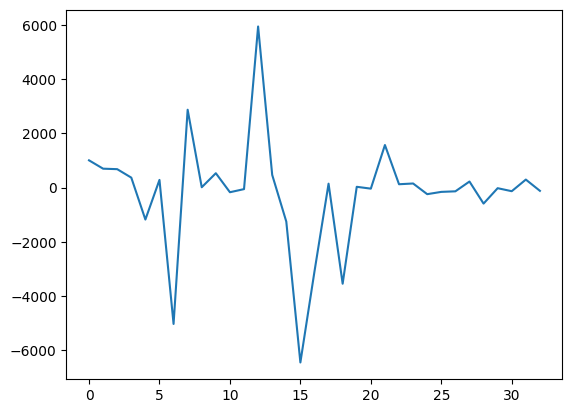

In [100]:
plt.plot(test["residuals"].to_list())

**Test2**: Durbin Watson Test

Null Hypothesis Ho : There is no autocorrelation of errors  
Alternate Hypothesis Ha : There is autocorrelation of errors  

The value of the statistic will lie between 0 to 4. A value between 1.8 and 2.2 indicates no autocorrelation. A value less than 1.8 indicates positive autocorrelation and a value greater than 2.2 indicates negative autocorrelation

In [102]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(test["residuals"])

1.8008122883598143

## Final Regression: statsmodels Views vs Likes

Based on test above, we will only retain view count as the independent variable

In [197]:
X = video_details[["view_count"]]
y = np.log(video_details["like_count"])

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [199]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [200]:
ols_model = sm.OLS(y_train, X_train).fit()
ols_model

In [201]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             like_count   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     78.61
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           3.32e-13
Time:                        13:00:11   Log-Likelihood:                -120.42
No. Observations:                  75   AIC:                             244.8
Df Residuals:                      73   BIC:                             249.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6410      0.161     35.038      0.000       5.320       5.962
view_count  1.436e-05   1.62e-06      8.866      0.000    1.11e-05    1.76e-05
==============================================================================
Omnibus:                       23.493   Durbin-Watson:                   2.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.535
Skew:                          -1.365   Prob(JB):                     8.61e-08
Kurtosis:                       4.719   Cond. No.                     1.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
y_train_pred = ols_model.predict(X_train)
y_test_pred = ols_model.predict(X_test)

In [203]:
print("""R2 = {:.4f}
Adj R2 = {:.4f}""".format(r2_score(y_test, y_test_pred),
                          adj_r2_score(y_test, y_test_pred, X_test)
                         ))

R2 = 0.5212
Adj R2 = 0.4892


In [204]:
train = pd.DataFrame({"y": y_train,
                      "y_pred": y_train_pred,
                      "residuals": y_train-y_train_pred})

test = pd.DataFrame({"y":y_test,
                     "y_pred":y_test_pred,
                     "residuals": y_test-y_test_pred})

### Checking assumptions involving residuals again

**Test1:** Mean of the residuals

In [205]:
print("""Mean of residuals = {}""".format(np.mean(test["residuals"])))

Mean of residuals = 0.2211392102244807


**Test2**: Plotting KDE plot of residuals

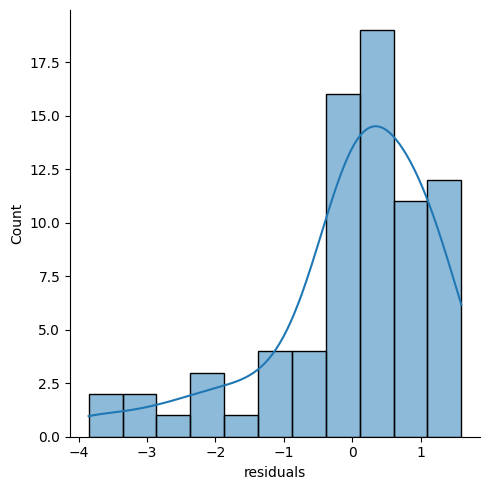

In [206]:
# train["residuals"].hist(bins=50)
sns.displot(train["residuals"], kde=True)

**Test3**: q-q plot

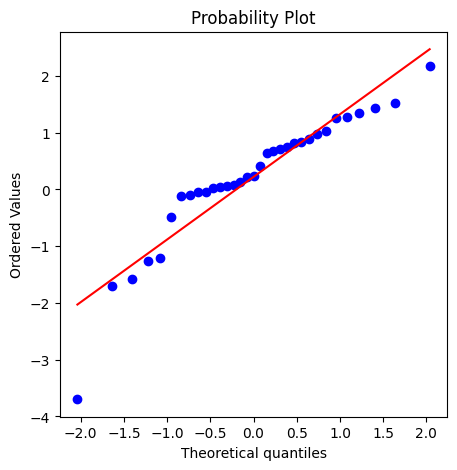

In [207]:
import scipy

f, axs = plt.subplots(figsize=(5,5))
scipy.stats.probplot(test["residuals"], plot=axs, fit=True)
plt.show()

**Test4**: Plotting residuals vs predictions

In the below plot, we see residuals not uniformly distributed, but forming a cone. Residual values are lower for lower values of y_pred and higher for higher values of y_pred

<Axes: xlabel='y_pred', ylabel='residuals'>

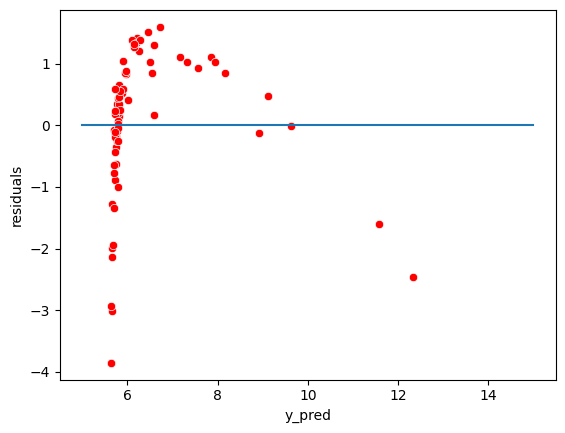

In [214]:
sns.scatterplot(x=train["y_pred"], y=train["residuals"], color="r")
sns.lineplot(x=[5,15], y=[0,0])

**Test5**: Breusch-pagan test

Null Hypothesis Ho: Error variances are equal (Homoscedasticity)  
Alternate Hypothesis Ha: Error variances are not equal (Heteroscedasticity)

Returns  
lm : float: lagrange multiplier statistic  
lm_pvalue : float: p-value of lagrange multiplier test  
fvalue : float: f-statistic of the hypothesis that the error variance does not depend on x  
f_pvalue : float: p-value for the f-statistic  

In [209]:
from statsmodels.stats.diagnostic import het_breuschpagan
sms.het_breuschpagan(test["residuals"], X_test)

(0.06292715272511973,
 0.8019278786400517,
 0.059226323587529835,
 0.8093262298090271)

In [210]:
bptest = het_breuschpagan(test["residuals"], X_test)[1]
print("The p value of Breuchpagen test is", bptest)

The p value of Breuchpagen test is 0.8019278786400517


**Test7**: Plot residuals

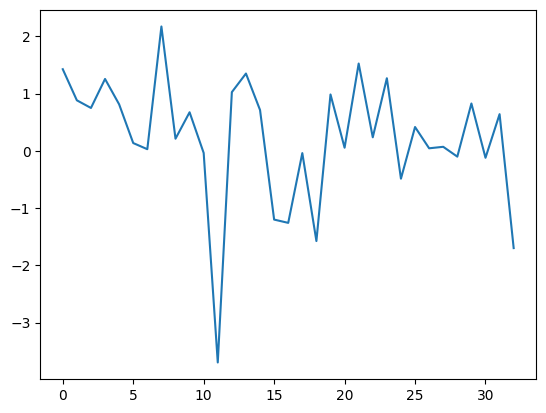

In [211]:
plt.plot(test["residuals"].to_list())

**Test8**: Durbin Watson Test

Null Hypothesis Ho : There is no autocorrelation of errors  
Alternate Hypothesis Ha : There is autocorrelation of errors  

The value of the statistic will lie between 0 to 4. A value between 1.8 and 2.2 indicates no autocorrelation. A value less than 1.8 indicates positive autocorrelation and a value greater than 2.2 indicates negative autocorrelation

In [212]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(test["residuals"])

1.8296385316952246